# Optimal Economic Dispatch in Distribution Feeders with Renewables using Convex Optimization
---
## Summary
This project utilizes convex optimization with application to the economic dispatch problem in power systems. The purpose of this is to optimally schedule distributed energy generators in a distribution feeder to minimize economic costs, while maintaining safe operating constraints. I utilize the convex DistFlow equations of Baran & Wu, which model power flow through radial distribution power networks. These equations model active & reactive power, branch power flow limits, node voltage limits, etc. This was completed as part of a class project in my MS program. Thanks to Prof. Scott Moura for providing data and overall framework on this. 

The mathematical formulation of this problem is not included in this document, although it is necessary to understand the constraints and forumlas presented in this notebook.

## Key questions explored
- Can we dispatch generators in a electrical network to minimize cost?
- How does the solution change when considering variable renewable generation?

## Techniques used
- convex optimization and relaxation
- energy systems engineering
- second-order cone programming to deal with stochasticity

## Key findings
- As we increase the complexity of the model, we add more constraints to power flow. This increases the minimum cost.
- The cost when considering renewable generation is slightly than if there were no renewables. This makes sense because renewables are variable and we don't know exactly how much power will be available from them. Thus, if we include renewables in our power flow schedule, we’ve introduced uncertainty and thus risk. There is a cost associated with this risk.

## Download cvxpy
`pip install cvxpy`

See directions here: https://www.cvxpy.org/install/

I recommend creating a separate pip virtualenv before installing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline
import pandas as pd

### 1. Define network parameters for the IEEE 13-node test feeder

In [2]:
# Node (aka Bus) Data
# l_j^P: Active power consumption [MW]
l_P = np.array([0, 0.2, 0, 0.4, 0.17, 0.23, 1.155, 
                0, 0.17, 0.843, 0, 0.17, 0.128])

# l_j^Q: Reactive power consumption [MVAr]
l_Q = np.array([0, 0.116, 0, 0.29, 0.125, 0.132, 
                0.66, 0, 0.151, 0.462, 0, 0.08, 0.086])

# l_j^S: Apparent power consumption [MVA]
l_S = np.sqrt(l_P**2 + l_Q**2)

# s_j,max: Maximal generating power [MW]
s_max = np.array([5, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0])

# c_j: Marginal generation cost [USD/MW]
c = np.array([100, 0, 0, 150, 0, 0, 0, 0, 0, 50, 0, 0, 0])

# V_min, V_max: Minimum and maximum nodal voltages [V]
v_min = 0.95
v_max = 1.05

### Edge (aka Line) Data
# r_ij: Resistance [p.u.]
r = np.array([
[0, 0.007547918, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0.0041, 0, 0.007239685, 0, 0.007547918, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.004343811, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0.003773959, 0, 0, 0.004322245, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00434686, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004343157, 0.01169764],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# x_ij: Reactance [p.u.]
x = np.array([
[0, 0.022173236, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0.0064, 0, 0.007336076, 0, 0.022173236, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.004401645, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0.011086618, 0, 0, 0.004433667, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002430473, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004402952, 0.004490848],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# I_max_ij: Maximal line current [p.u.]
I_max = np.array([
[0, 3.0441, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1.4178, 0, 0.9591, 0, 3.0441, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 3.1275, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.9591, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 3.0441, 3.1275, 0, 0.9591, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.37193, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9591, 1.2927],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# A_ij: Adjacency matrix; A_ij = 1 if i is parent of j
A = np.array([
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# Set Data
# List of node indices
j_idx = np.arange(13)

# \rho(j): Parent node of node j
rho = np.array([0, 0, 1, 2, 1, 4, 1, 6, 6, 8, 6, 10, 10])

### 2. Plot activate and reactive power consumption at each node
This will help provide better intuition for our data.

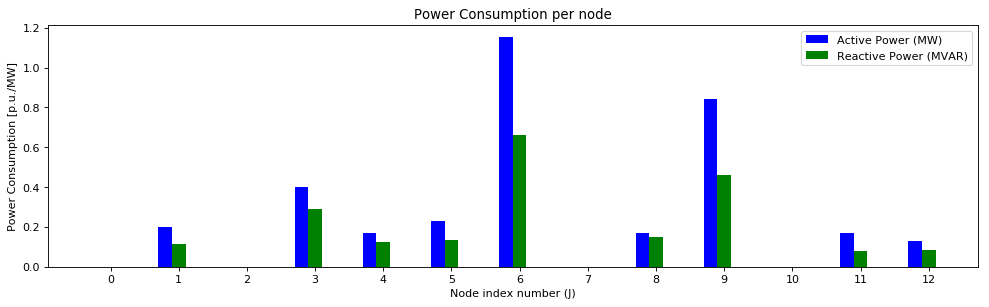

In [3]:
# Plot active and reactive power consumption
plt.figure(num=1, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
 
# create plot
width = 0.2
plt.bar(j_idx - width, l_P, width,
                 color='b',
                 label='Active Power (MW)')
plt.bar(j_idx, l_Q, width,
                 color='g',
                 label='Reactive Power (MVAR)')
plt.xticks(j_idx)
plt.xlabel('Node index number (J)')
plt.ylabel('Power Consumption [p.u./MW]')
plt.title('Power Consumption per node')
plt.legend()
plt.show()

### 3. Simple model - balance supply and demand only
Since the task at hand is non-trivial, I will first break it down into a simpler problem. Here I will disregard the entire network diagram. That is, I seek to balance active & reactive power supply & demand, while
minimizing generation cost and completely ignoring line losses and constraints. Instead, I will balance supply and demand without network considerations. The goal is to minimize generation costs, given by $c^Ts$. This is achieved by using the `cvxpy` package.

In [4]:
# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)

# Define objective function
objective = Minimize(c*s)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Balance power generation with power consumption
constraints += [sum(p) == sum(l_P), sum(q) == sum(l_Q)]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation
    constraints += [p[jj] >= 0, q[jj] >= 0]
    # Compute apparent power from active & reactive power
    constraints += [norm(vstack((p[jj],q[jj]))) <= s[jj]]
    
# Define problem and solve
balance_only = Problem(objective, constraints)
balance_only.solve()

255.35860662961574

In [5]:
# Output Results
print("------------------ NO NETWORK --------------------")
print("--------------------------------------------------")
print(balance_only.status)
print(f"Minimum Generating Cost : {np.round(balance_only.value, 2)} USD")
print(" ")
print(f"Node 0 [Grid]  Gen Power : p_0 = {np.round(p[0].value, 3)} MW | q_0 = {np.round(q[0].value, 3)} MW | s_0 = {np.round(s[0].value, 3)} MW || mu_s0 = {np.round(constraints[0].dual_value[0])} USD/MW")
print(f"Node 3 [Gas]   Gen Power : p_3 = {np.round(p[3].value, 3)} MW | q_3 = {np.round(q[3].value, 3)} MW | s_0 = {np.round(s[3].value, 3)} MW || mu_s3 = {np.round(constraints[0].dual_value[3])} USD/MW")
print(f"Node 9 [Solar] Gen Power : p_3 = {np.round(p[9].value, 3)} MW | q_3 = {np.round(q[9].value, 3)} MW | s_0 = {np.round(s[9].value, 3)} MW || mu_s9 = {np.round(constraints[0].dual_value[9])} USD/MW")
print(" ")
print(f"Total active power   : {np.round(np.sum(l_P), 3)} MW   consumed | {np.round(np.sum(p.value), 3)} MW   generated")
print(f"Total reactive power : {np.round(np.sum(l_Q), 3)} MVAr consumed | {np.round(np.sum(q.value), 3)} MVAr generated")
print(f"Total apparent power : {np.round(np.sum(l_S), 3)} MVA  consumed | {np.round(np.sum(s.value), 3)} MVA  generated")
print(" ")

------------------ NO NETWORK --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW || mu_s0 = 0.0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.0 MW | q_3 = 0.0 MW | s_0 = 0.0 MW || mu_s3 = 0.0 USD/MW
Node 9 [Solar] Gen Power : p_3 = 2.565 MW | q_3 = 1.556 MW | s_0 = 3.0 MW || mu_s9 = 50.0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated
 


### 4. Add power line flows
I'm building up to the full model. Next, I add line power flows $P_{ij}$, $Q_{ij}$ but still neglect the nodal voltage $V_j$ and $L_{ij}$ terms. 

In [6]:
# Assumptions:
#   - Disregard L_ij, the squared magnitude of complex line current
#   - Disregard nodal voltage equation
#   - Disregard nodal voltage limits
#   - Disregard maximum line current
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable((13, 13))
Q = Variable((13, 13))

# Define objective function
objective = Minimize(c*s)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Boundary condition for power line flows
constraints += [P[0,0] == 0, Q[0,0] == 0]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    ii = rho[jj]
    
    # Line Power Flows
    constraints += [P[ii,jj] == l_P[jj] - p[jj] + A[jj,:]*P[jj,:].T,
                    Q[ii,jj] == l_Q[jj] - q[jj] + A[jj,:]*Q[jj,:].T]

    # Compute apparent power from active & reactive power
    constraints += [norm(vstack((p[jj], q[jj]))) <= s[jj]]

# Define problem and solve
line_flows = Problem(objective, constraints)
line_flows.solve()


255.3586066145166

In [7]:
# Output Results
print("---------------- LINE FLOWS ONLY -----------------")
print("--------------------------------------------------")
print(line_flows.status)
print(f"Minimum Generating Cost : {np.round(line_flows.value, 2)} USD")
print(" ")
print(f"Node 0 [Grid]  Gen Power : p_0 = {np.round(p[0].value, 3)} MW | q_0 = {np.round(q[0].value, 3)} MW | s_0 = {np.round(s[0].value, 3)} MW || mu_s0 = {np.round(constraints[0].dual_value[0])} USD/MW")
print(f"Node 3 [Gas]   Gen Power : p_3 = {np.round(p[3].value, 3)} MW | q_3 = {np.round(q[3].value, 3)} MW | s_0 = {np.round(s[3].value, 3)} MW || mu_s3 = {np.round(constraints[0].dual_value[3])} USD/MW")
print(f"Node 9 [Solar] Gen Power : p_3 = {np.round(p[9].value, 3)} MW | q_3 = {np.round(q[9].value, 3)} MW | s_0 = {np.round(s[9].value, 3)} MW || mu_s9 = {np.round(constraints[0].dual_value[9])} USD/MW")
print(" ")
print(f"Total active power   : {np.round(np.sum(l_P), 3)} MW   consumed | {np.round(np.sum(p.value), 3)} MW   generated")
print(f"Total reactive power : {np.round(np.sum(l_Q), 3)} MVAr consumed | {np.round(np.sum(q.value), 3)} MVAr generated")
print(f"Total apparent power : {np.round(np.sum(l_S), 3)} MVA  consumed | {np.round(np.sum(s.value), 3)} MVA  generated")
print(" ")

---------------- LINE FLOWS ONLY -----------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW || mu_s0 = 0.0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.0 MW | q_3 = 0.0 MW | s_0 = 0.0 MW || mu_s3 = 0.0 USD/MW
Node 9 [Solar] Gen Power : p_3 = 2.565 MW | q_3 = 1.556 MW | s_0 = 3.0 MW || mu_s9 = 50.0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated
 


### 5. Full economic dispatch with DistFlow equations
Now I'm ready to solve the full economic dispatch. I now add the nodal voltages $V_j$, squared current magnitudes $L_{ij}$, and their bounds. This incorporates impedance (i.e. losses) across the network, along with nodal voltage and line transmission limits.

In [8]:
# Assumptions:
#   - Add back all previously disregarded terms and constraints
#   - Relax squared line current equation into inequality
#   - Goal is to minimize generation costs, given by c^T s

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable((13,13))
Q = Variable((13,13))
L = Variable((13,13))
V = Variable(13)

# Define objective function
objective = Minimize(c*s)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Nodal voltage limits
constraints += [v_min**2 <= V,
                V <= v_max**2]

# Squared line current limits
constraints += [L <= I_max**2]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    ii = rho[jj]
    
    # Line Power Flows
    constraints += [P[ii,jj] == l_P[jj] - p[jj] + r[ii,jj]*L[ii,jj] + A[jj,:]*P[jj,:].T,
                    Q[ii,jj] == l_Q[jj] - q[jj] + x[ii,jj]*L[ii,jj] + A[jj,:]*Q[jj,:].T]

    # Nodal voltage
    constraints += [V[jj] == V[ii] + (r[ii,jj]**2 + x[ii,jj]**2)*L[ii,jj] - 
                    2*(r[ii,jj]*P[ii,jj] + x[ii,jj]*Q[ii,jj])]
    
    # Squared current magnitude on lines
    constraints += [L[ii,jj] >= quad_over_lin(vstack((P[ii,jj],Q[ii,jj])),V[jj])]
    
    # Compute apparent power from active & reactive power
    constraints += [norm(vstack((p[jj],q[jj]))) <= s[jj]]
    

# Define problem and solve
full_network = Problem(objective, constraints)
full_network.solve()

299.6867745233192

In [9]:
# Output Results
print("----------------- FULL NETWORK -------------------")
print("--------------------------------------------------")
print(full_network.status)
print(f"Minimum Generating Cost : {np.round(full_network.value, 2)} USD")
print(" ")
print(f"Node 0 [Grid]  Gen Power : p_0 = {np.round(p[0].value, 3)} MW | q_0 = {np.round(q[0].value, 3)} MW | s_0 = {np.round(s[0].value, 3)} MW || mu_s0 = {np.round(constraints[0].dual_value[0])} USD/MW")
print(f"Node 3 [Gas]   Gen Power : p_3 = {np.round(p[3].value, 3)} MW | q_3 = {np.round(q[3].value, 3)} MW | s_0 = {np.round(s[3].value, 3)} MW || mu_s3 = {np.round(constraints[0].dual_value[3])} USD/MW")
print(f"Node 9 [Solar] Gen Power : p_3 = {np.round(p[9].value, 3)} MW | q_3 = {np.round(q[9].value, 3)} MW | s_0 = {np.round(s[9].value, 3)} MW || mu_s9 = {np.round(constraints[0].dual_value[9])} USD/MW")
print(" ")
print(f"Total active power   : {np.round(np.sum(l_P), 3)} MW   consumed | {np.round(np.sum(p.value), 3)} MW   generated")
print(f"Total reactive power : {np.round(np.sum(l_Q), 3)} MVAr consumed | {np.round(np.sum(q.value), 3)} MVAr generated")
print(f"Total apparent power : {np.round(np.sum(l_S), 3)} MVA  consumed | {np.round(np.sum(s.value), 3)} MVA  generated")
print(" ")
for jj in j_idx:
    print(f"Node {jj} Voltage : {np.round((V[jj].value)**0.5, 3)} p.u.")

----------------- FULL NETWORK -------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 299.69 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.568 MW | q_0 = 0.985 MW | s_0 = 1.852 MW || mu_s0 = 0.0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = -0.0 MW | q_3 = 0.0 MW | s_0 = 0.0 MW || mu_s3 = 0.0 USD/MW
Node 9 [Solar] Gen Power : p_3 = 1.941 MW | q_3 = 1.216 MW | s_0 = 2.29 MW || mu_s9 = 0.0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.509 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.201 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.142 MVA  generated
 
Node 0 Voltage : 1.0 p.u.
Node 1 Voltage : 0.967 p.u.
Node 2 Voltage : 0.963 p.u.
Node 3 Voltage : 0.963 p.u.
Node 4 Voltage : 0.962 p.u.
Node 5 Voltage : 0.96 p.u.
Node 6 Voltage : 0.957 p.u.
Node 7 Voltage : 0.957 p.u.
Node 8 Voltage : 0.957 p.u.
Node 9 Voltage : 0.964 p.u.
Node 10 Voltage : 0.955 p.u.
Node 11 Voltage : 0.954 p.u.
Node 12 Voltage : 0.953 p.

### 6. Robust economic dispatch with variable renewables sources
So far, I've explored a network that includes only non-renewable sources. In these scenarios, the generating capacity of each source is known. Now, we assume renewables are available, which have an unknown generating capacity. More specifically, I assume there's now a solar generator at node 9 that is comprised of two solar panels, A and B. The output of each panel is uncertain, and weather dependent.

In [10]:
# Assumptions:
#   - Assume solar generator at node 9 has uncertain power capacity
#   - Goal is to minimize generation costs, given by c^T s, in face of uncertainty

# Second order cone constraint parameters
a_bar = np.array([[1.], [-1.25], [-1.25]])
E = np.diag([0, 0.25, 0.25])
b = 0

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable((13,13))
Q = Variable((13,13))
L = Variable((13,13))
V = Variable(13)
sig = Variable(2)

# Define objective function
objective = Minimize(c*s)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Nodal voltage limits
constraints += [v_min**2 <= V,
                V <= v_max**2]

# Squared line current limits
constraints += [L <= I_max**2]

# Second order cone constraint for solar generator on node 9
constraints += [a_bar.T * vstack([s[9], sig[0], sig[1]]) + norm(E.T * vstack([s[9], sig[0], sig[1]])) <= b,
                0 <= sig,
                sig <= 1]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    ii = rho[jj]
    
    # Line Power Flows
    constraints += [P[ii,jj] == l_P[jj] - p[jj] + r[ii,jj]*L[ii,jj] + A[jj,:]*P[jj,:].T,
                    Q[ii,jj] == l_Q[jj] - q[jj] + x[ii,jj]*L[ii,jj] + A[jj,:]*Q[jj,:].T]

    # Nodal voltage
    constraints += [V[jj] == V[ii] + (r[ii,jj]**2 + x[ii,jj]**2)*L[ii,jj] - 2*(r[ii,jj]*P[ii,jj] + x[ii,jj]*Q[ii,jj])]
    
    # Squared current magnitude on lines
    constraints += [L[ii,jj] >= quad_over_lin(vstack([P[ii,jj],Q[ii,jj]]),V[jj])]
    
    # Compute apparent power from active & reactive power
    constraints += [norm(vstack([p[jj],q[jj]])) <= s[jj]]
    

# Define problem and solve
robust_with_renewables = Problem(objective, constraints)
robust_with_renewables.solve()

308.72071356743197

In [11]:
print("------ ROBUST OPTIMIZATION WITH RENEWABLES -------")
print("--------------------------------------------------")
print(robust_with_renewables.status)
print(f"Minimum Generating Cost : {np.round(robust_with_renewables.value, 2)} USD")
print(" ")
print(f"Node 0 [Grid]  Gen Power : p_0 = {np.round(p[0].value, 3)} MW | q_0 = {np.round(q[0].value, 3)} MW | s_0 = {np.round(s[0].value, 3)} MW || mu_s0 = {np.round(constraints[0].dual_value[0])} USD/MW")
print(f"Node 3 [Gas]   Gen Power : p_3 = {np.round(p[3].value, 3)} MW | q_3 = {np.round(q[3].value, 3)} MW | s_0 = {np.round(s[3].value, 3)} MW || mu_s3 = {np.round(constraints[0].dual_value[3])} USD/MW")
print(f"Node 9 [Solar] Gen Power : p_3 = {np.round(p[9].value, 3)} MW | q_3 = {np.round(q[9].value, 3)} MW | s_0 = {np.round(s[9].value, 3)} MW || mu_s9 = {np.round(constraints[0].dual_value[9])} USD/MW")
print(" ")
print(f"Total active power   : {np.round(np.sum(l_P), 3)} MW   consumed | {np.round(np.sum(p.value), 3)} MW   generated")
print(f"Total reactive power : {np.round(np.sum(l_Q), 3)} MVAr consumed | {np.round(np.sum(q.value), 3)} MVAr generated")
print(f"Total apparent power : {np.round(np.sum(l_S), 3)} MVA  consumed | {np.round(np.sum(s.value), 3)} MVA  generated")
print(" ")
for jj in j_idx:
    print(f"Node {jj} Voltage : {np.round((V[jj].value)**0.5, 3)} p.u.")

------ ROBUST OPTIMIZATION WITH RENEWABLES -------
--------------------------------------------------
optimal
Minimum Generating Cost : 308.72 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.745 MW | q_0 = 1.006 MW | s_0 = 2.014 MW || mu_s0 = 0.0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.0 MW | q_3 = 0.0 MW | s_0 = -0.0 MW || mu_s3 = 0.0 USD/MW
Node 9 [Solar] Gen Power : p_3 = 1.77 MW | q_3 = 1.215 MW | s_0 = 2.146 MW || mu_s9 = 0.0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.514 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.221 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.16 MVA  generated
 
Node 0 Voltage : 1.0 p.u.
Node 1 Voltage : 0.965 p.u.
Node 2 Voltage : 0.961 p.u.
Node 3 Voltage : 0.961 p.u.
Node 4 Voltage : 0.96 p.u.
Node 5 Voltage : 0.958 p.u.
Node 6 Voltage : 0.954 p.u.
Node 7 Voltage : 0.954 p.u.
Node 8 Voltage : 0.954 p.u.
Node 9 Voltage : 0.96 p.u.
Node 10 Voltage : 0.952 p.u.
Node 11 Voltage : 0.951 p.u.
Node 12 Voltage : 0.95 p.u.
